# **References**:
1. https://www.kaggle.com/ilyamich/mfcc-implementation-and-tutorial
2. https://medium.com/@jonathan_hui/speech-recognition-feature-extraction-mfcc-plp-5455f5a69dd9
3. http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/


# **Importing Libraries** 

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import get_window
import scipy.fftpack as fft
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score, mean_squared_error
import torch
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder
from torch import optim
import time
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
import copy

# **Function Definition** 

In [0]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100): # hop_size in ms
  audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
  frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
  frame_num = int((len(audio) - FFT_size) / frame_len) + 1
  frames = np.zeros((frame_num,FFT_size))
  
  for n in range(frame_num):
      frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
  
  return frames

def freq_to_mel(freq):
  return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
  return 700.0 * (10.0**(mels / 2595.0) - 1.0)

def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
  fmin_mel = freq_to_mel(fmin)
  fmax_mel = freq_to_mel(fmax)
  
#  print("MEL min: {0}".format(fmin_mel))
#  print("MEL max: {0}".format(fmax_mel))
  
  mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
  freqs = met_to_freq(mels)
  
  return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

def get_filters(filter_points, FFT_size):
  filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
  
  for n in range(len(filter_points)-2):
    filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
    filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
  
  return filters

def dct(dct_filter_num, filter_len):
  basis = np.empty((dct_filter_num,filter_len))
  basis[0, :] = 1.0 / np.sqrt(filter_len)
  
  samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

  for i in range(1, dct_filter_num):
    basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
      
  return basis

def run_FFNN(X_train_scaled,X_test_scaled,Y_OH_train,Y_OH_test,class_name="FFNNetwork_Regularized",Epochs=6000,save_fig = True, save_dir='/content/VOICE_dataset/Outputs/', save_name='FFNN_with_PyTorch'):
  if(class_name == "FFNNetwork_Regularized"):
    fn = FFNNetwork_Regularized()
  elif(class_name == "FFNNetwork"):
    fn = FFNNetwork()
  loss_fn = fn.cross_entropy
  opt = optim.SGD(fn.parameters(), lr=0.9)
  #opt = optim.Adam(fn.parameters(),weight_decay=0.05)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  X_train_scaled = X_train_scaled.to(device)
  Y_OH_train = Y_OH_train.to(device)
  fn.to(device)

  tic = time.time()
  best_model = fit(X_train_scaled, Y_OH_train, fn, opt, loss_fn, epochs=Epochs)
  toc = time.time()
  fn.load_state_dict(best_model)
  print("Time for training model: {}s".format(np.round(toc-tic,3)))

  X_test_scaled =X_test_scaled.to(device)
  Y_OH_test=Y_OH_test.to(device)
  
  for k in [1]:
    accuracy_train = fn.accuracy_n(fn.forward(X_train_scaled),Y_OH_train, topk=(k,))[0].item()
    print('Training Accuracy (top-{}): {}'.format(k,accuracy_train))


    accuracy_test = fn.accuracy_n(fn.forward(X_test_scaled),Y_OH_test, topk=(k,))[0].item()
    print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))
    print('\n')
    
  cm = confusion_matrix(torch.argmax(Y_OH_test,dim=1).to("cpu").numpy(), torch.argmax(fn.forward(X_test_scaled), dim=1).to("cpu").to("cpu").detach().numpy())
  #print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  #ax.set_xticklabels([''] + labels)
  #ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
    plt.savefig(save_dir+save_name+'_Confusion_matrix.png')
  else:
    plt.show()    

#  if(save_model == True):
#    torch.save(fn.to("cpu").state_dict(), model_save_dir )
#    torch.save(fn.state_dict(), save_dir) # saving the model

  return fn.forward(X_test_scaled), accuracy_test, fn

def fit(x, y, model, opt, loss_fn, epochs = 1000,save_fig = True, save_dir='/content/VOICE_dataset/Outputs/', save_name='FFNN_with_PyTorch_loss'):
  min_loss = 10000
  loss_arr = []
  acc_arr = []
  for epoch in range(epochs):
    x, y = shuffle(x, y, random_state=0)
    y_hat = model.forward(x)
    loss = loss_fn(y_hat, y)
    loss_arr.append(loss.item())
    acc_arr.append(model.accuracy(y_hat,y))
    loss.backward()
    opt.step()
    opt.zero_grad()
    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(model.state_dict())
  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.xlabel("Epoch")
  plt.ylabel("Cross Entropy Loss")
  if(save_fig):
    plt.savefig(save_dir+save_name+'_loss.png')
  else:
    plt.show()      
  print('Loss before training', loss_arr[0])
  print('Loss after training', min_loss)
  return best_model

# **Data Reduction**

1. Generation of MFCC.
2. Generation of Delta and Delta Delta coefficients.

In [0]:
!unzip Male_Voice.zip

In [0]:
!unzip Female_Voice.zip

In [0]:
!unzip Outputs.zip

## Enter here the number of male audio files and female audio files used.

In [0]:
num_files = [50,50] # [num_male_audio_files , num_female_audio_files]

## Enter number of Mel Frequency Cepstral Coefficients to be used

In [0]:
num_mfcc = 18

In [105]:
path = '/content'
file_names = np.array(["/Male Voice/male","/Female Voice/female"])
male_data = np.array([])
female_data = np.array([])
for i in (range(file_names.size)):
  for j in range(num_files[i]):
    sample_rate, audio = wavfile.read(path+file_names[i]+"_"+str(j+1)+".wav")
    if(audio.ndim == 2):
      audio = audio.T[0]
    norm_audio = audio/np.amax(np.abs(audio))
    hop_size = 15 #ms
    FFT_size = 2048

    audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
    window = get_window("hann", FFT_size, fftbins=True)
    audio_win = audio_framed * window
    audio_winT = np.transpose(audio_win)

    audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

    for n in range(audio_fft.shape[1]):
      audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

    audio_fft = np.transpose(audio_fft)
    audio_power = np.square(np.abs(audio_fft))
    freq_min = 0
    freq_high = sample_rate / 2
    mel_filter_num = 10
    filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
    if((i == 1 and j == 16) or (i == 1 and j == 15)):
      print(filter_points.shape)
    filters = get_filters(filter_points, FFT_size)
    enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
    filters *= enorm[:, np.newaxis]
    audio_filtered = np.dot(filters, np.transpose(audio_power))
    eps = 10**(-16)
    for l in range(audio_filtered.shape[0]):
      for m in range(audio_filtered.shape[1]):
        if(audio_filtered[l][m] == 0.0):
          audio_filtered[l][m] = eps
    audio_log = 10.0 * np.log10(audio_filtered)
    dct_filter_num = num_mfcc

    dct_filters = dct(dct_filter_num, mel_filter_num)

    cepstral_coefficents = np.dot(dct_filters, audio_log)
    cepstral_coefficents = np.mean(cepstral_coefficents, axis=1)
    cep_features = cepstral_coefficents
    #cep_features = np.append(cepstral_coefficents,np.sum(cepstral_coefficents**2))
    delta = np.gradient(cep_features)
    delta_delta = np.gradient(delta)

    if(i == 0):
      if(male_data.size == 0):
        male_data = np.hstack((cep_features,delta,delta_delta))
      else:
        male_data = np.row_stack((male_data,np.hstack((cep_features,delta,delta_delta))))
    elif(i == 1):
      if(female_data.size == 0):
        female_data = np.hstack((cep_features,delta,delta_delta))
      else:
        female_data = np.row_stack((female_data,np.hstack((cep_features,delta,delta_delta))))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: WavFileWarning: Reached EOF prematurely; finished at 376068 bytes, expected 632876 bytes from header.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: WavFileWarning: Reached EOF prematurely; finished at 226988 bytes, expected 226996 bytes from header.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: WavFileWarning: Reached EOF prematurely; finished at 1394556 bytes, expected 1394564 bytes from header.
  import sys


(12,)
(12,)


# **Classifier and Related Functions Definitions**

Following three classifiers are used:
1. Gaussian Naive Bayes
2. k Nearest Neighbours
3. Perceptron Model (sigmoid neuron)

The accuracy scores are used as metric for comparing classifier efficieny. 

# Gaussian Naive Bayes

In [0]:
def gaussian_function(x,m,s):
  x = np.array(x);
  m = np.array(m);
  s = np.array(s);
  k = m.size;
  factor = 1/np.sqrt(((2*np.pi)**k)*np.linalg.det(s));
  ret_arr = []
  for i in range(x.shape[0]):
    exponent = (-0.5) * np.matmul(np.matmul((x[i]-m),np.linalg.inv(s)),(x[i]-m).T);
    ret_arr.append(np.exp(exponent))

  return factor*np.array(ret_arr)

def naive_bayes_classifier(x,name=None):
  x = np.array(x)
  z = []
  if(name == None):
    for i in range(x.shape[0]):
      z.append(np.argmax(x[i])+1)
  else:
    for i in range(x.shape[0]):
      z.append(name[np.argmax(x[i])])
  return z

def get_accuracy(x,y):
  x = np.array(x)
  y = np.array(y)
  accuracy = 0.0
  for i in range(x.size):
    if(x[i] == y[i]):
      accuracy += 1;
  return (accuracy/x.size)*100;
  
def MLE_BDT(male_train_data, female_train_data, test_data, test_classes, p, whitener=True): # P = [0.7,0.3], p = [1/3,1/3,1/3]
  
  if(whitener == True):
    male_train_data = whiten(male_train_data)
    female_train_data = whiten(female_train_data)

  m = np.array([np.mean(male_train_data, axis=0), np.mean(female_train_data, axis=0)])

  s = np.zeros((2,male_train_data.shape[1]))
  for i in range(2):
    for j in range(male_train_data.shape[1]):
      if(i == 0):
        s[i][j] = np.var(male_train_data.T[j])
      elif(i == 1):
        s[i][j] = np.var(female_train_data.T[j])

  s = np.array([np.diag(s[0]),np.diag(s[1])])

  p_x_0 = gaussian_function(np.concatenate((male_train_data,female_train_data)),m[0],s[0])
  p_x_1 = gaussian_function(np.concatenate((male_train_data,female_train_data)),m[1],s[1])

  p_0_x = (p_x_0*p[0])/(p_x_0*p[0] + p_x_1*p[1])
  p_1_x = (p_x_1*p[1])/(p_x_0*p[0] + p_x_1*p[1])

  train_pred = naive_bayes_classifier(\
    np.column_stack((p_0_x,p_1_x)))

  train_accuracy = get_accuracy(train_pred, np.hstack((np.zeros(male_train_data.shape[0]),np.ones(female_train_data.shape[0]))))

  print("Accuracy of model on training set is: {}%".format(train_accuracy))

  p_x_0 = gaussian_function(test_data,m[0],s[0])
  p_x_1 = gaussian_function(test_data,m[1],s[1])

  p_0_x = (p_x_0*p[0])/(p_x_0*p[0] + p_x_1*p[1])
  p_1_x = (p_x_1*p[1])/(p_x_0*p[0] + p_x_1*p[1])

  test_pred = naive_bayes_classifier(\
    np.column_stack((p_0_x,p_1_x)))

  test_accuracy = get_accuracy(test_pred, test_classes)

  print("Accuracy of model on testing set is: {}%".format(test_accuracy))


## Enter the fraction of dataset to be used for testing purpose

In [0]:
test_split_frac_GNB = 0.3

In [0]:
male_train, male_test = train_test_split(male_data, test_size = test_split_frac_GNB)
female_train, female_test = train_test_split(female_data, test_size = test_split_frac_GNB)

In [0]:
test_data = np.vstack((male_test, female_test))
test_classes = np.hstack((np.zeros(male_test.shape[0]), np.ones(female_test.shape[0])))

In [0]:
MLE_BDT(male_train, female_train, test_data, test_classes, [0.5,0.5], whitener=False)

Accuracy of model on training set is: 4.285714285714286%
Accuracy of model on testing set is: 10.0%


## **Inferences:**

1. We observe that the accuracy on both training and testing data is very poor. As the number of data samples of each class are equal in number, even if we classify all the data as belonging to either class, we must get close to 50% accuracy. 
  
2. Thus, we infer that the assumption of mutual independence of features implicit in the Naive Bayes method, is not satisfied. We hypothesize this to be the reason for poor performance of the classifier. 

# k-NN

## **Theory**

KNN Algorithm is based on feature similarity: How closely out-of-sample features resemble our training set determines how we classify a given data point.

KNN can be used for classification — the output is a class membership (predicts a class — a discrete value). An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors. It can also be used for regression — output is the value for the object (predicts continuous values). This value is the average (or median) of the values of its k nearest neighbors. 

Commonly used distance measures include: Mahalnobis distance, Euclidean distance, etc.,

In the classification phase, k is a user-defined constant, and an unlabeled vector (a query or test point) is classified by assigning the label which is most frequent among the k training samples nearest to that query point.

**Advantages:**

• No assumptions about data — useful, for example, for nonlinear data 

• Simple algorithm — to explain and understand/interpret 

• High accuracy (relatively) — it is pretty high but not competitive in comparison to better supervised learning models 

• Versatile — useful for classification or regression 
 
**Disadvantages:** 

• Computationally expensive — because the algorithm stores all of the training data 

• High memory requirement 

• Stores all (or almost all) of the training data 

• Prediction stage might be slow (with big N) 

• Sensitive to irrelevant features and the scale of the data



In [0]:
def euclideanDistance(x,y):
  distance = 0
  for i in range(x.size):
    distance += (x[i] - y[i])**2
  return np.sqrt(distance)

def first_comes_first(arr,x):
    arr[1:] = arr[0:-1]
    arr[0] = x
    return arr

def kNN(test_data,train_data,train_class,k):
  test_pred = np.zeros(test_data.shape[0])
  for i in range(test_data.shape[0]):
    dist_arr = np.asarray(np.zeros(k))
    nearest = np.asarray(np.zeros(k))
    ret_arr = np.array([])
    for j in range(k):
      dist_arr[j] = euclideanDistance(train_data[j],test_data[i])
      nearest[j]=j

    for j in range(train_data.shape[0]):
      temp_dist = euclideanDistance(test_data[i],train_data[j])
      if(temp_dist <= np.amin(dist_arr)):
        dist_arr = first_comes_first(dist_arr,temp_dist)
        nearest = first_comes_first(nearest,j)

    for j in (nearest):
      ret_arr = np.append(ret_arr,train_class[int(j)])
    ret_arr = np.array([int(q) for q in ret_arr])
    test_pred[i] = np.argmax(np.bincount(ret_arr))

  return test_pred



In [0]:
def getAccuracy(testSet, predictions):
  correct = 0
  testSet = np.array(testSet)
  for x in range(testSet.shape[0]):
    if (testSet[x] == predictions[x]):
      correct += 1
  return (correct/float(testSet.shape[0])) * 100.0

## Enter the fraction of dataset to be used for testing purpose

In [0]:
test_split_frac_kNN = 0.2

In [0]:
male_train, male_test = train_test_split(male_data, test_size = test_split_frac_kNN)
female_train, female_test = train_test_split(female_data, test_size = test_split_frac_kNN)

In [0]:
kf = KFold(n_splits=5)
acc_arr = np.zeros((5,10))
ctr = 0
for train_index, test_index in kf.split(male_data):
  male_train_data, male_test_data = male_data[train_index], male_data[test_index]
  female_train_data, female_test_data = female_data[train_index], female_data[test_index]

  test_data = np.concatenate((male_test_data,female_test_data))
  test_class = np.append(np.zeros(male_test_data.shape[0]),np.ones(female_test_data.shape[0]))

  train_data = np.concatenate((male_train_data, female_train_data))
  train_class = np.append(np.zeros(male_train_data.shape[0]),np.ones(female_train_data.shape[0]))
  for k in range(10): # we check accuracy when k-NN method is used with k = 1,2,3,4,5,6,7,8,9,10.
    test_pred = kNN(test_data, train_data, train_class, k+1)
    acc = getAccuracy(test_class, test_pred)
    acc_arr[ctr][k] = acc
  ctr += 1

In [0]:
np.mean(acc_arr, axis=0) # 5 fold 

array([62., 57., 57., 53., 53., 50., 50., 50., 50., 50.])

In [0]:
kf = KFold(n_splits=10)
acc_arr = np.zeros((10,10))
ctr = 0
for train_index, test_index in kf.split(male_data):
  male_train_data, male_test_data = male_data[train_index], male_data[test_index]
  female_train_data, female_test_data = female_data[train_index], female_data[test_index]

  test_data = np.concatenate((male_test_data,female_test_data))
  test_class = np.append(np.zeros(male_test_data.shape[0]),np.ones(female_test_data.shape[0]))

  train_data = np.concatenate((male_train_data, female_train_data))
  train_class = np.append(np.zeros(male_train_data.shape[0]),np.ones(female_train_data.shape[0]))
  for k in range(10):
    test_pred = kNN(test_data, train_data, train_class, k+1)
    acc = getAccuracy(test_class, test_pred)
    acc_arr[ctr][k] = acc
  ctr += 1

In [0]:
np.mean(acc_arr, axis=0) # 10 fold 

array([67., 58., 58., 54., 54., 52., 52., 50., 50., 50.])

## **Inferences:**

1. We observe that the accuracy on both training and testing data is better than that obtained using Gaussian Naive Bayes classifier but still poor. 

2. We observe that the accuracy drops with increase in the k value in the k-NN method and nearly satuartes as k value approaches 10.
  
3. Here, we have used k-fold cross validation to remove bias due to inital seeding of the training and testing samples. Then, we have computed the mean values of accuracy across the k-fold values.

# **FFNN**

In [0]:
scaler = StandardScaler()
male_scaled_data = scaler.fit_transform(male_data)
female_scaled_data = scaler.fit_transform(female_data)
male_train, male_test = train_test_split(male_scaled_data, test_size = 0.3)
female_train, female_test = train_test_split(female_scaled_data, test_size = 0.3)
train_data = np.row_stack((male_train, female_train))
train_class = np.append(np.zeros(male_train.shape[0]),np.ones(female_train.shape[0]))
test_data = np.row_stack((male_test, female_test))
test_class = np.append(np.zeros(male_test.shape[0]),np.ones(female_test.shape[0]))

In [0]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(train_class,1)).toarray()
Y_OH_val = enc.fit_transform(np.expand_dims(test_class,1)).toarray()

In [0]:
X_train_scaled, Y_train,Y_OH_train, X_val_scaled, Y_val,Y_OH_val = map(torch.tensor, (train_data, train_class,Y_OH_train, test_data, test_class,Y_OH_val))

X_train_scaled = X_train_scaled.float()
Y_train = Y_train.long()

X_val_scaled = X_val_scaled.float()
Y_val = Y_val.long()


In [0]:

# simply define a silu function
def hakuna_matata(x,x0 = 0,a=1):
  return 2/(1+torch.exp(-a*(x-x0))) - 1 # use torch.sigmoid to make sure that we created the most efficient implemetation based on builtin PyTorch functions

# create a class wrapper from PyTorch nn.Module, so
# the function now can be easily used in models
class Hakuna_Matata(nn.Module):
  def __init__(self,x0=0,a=1):
    super().__init__() # init the base class
    self.a = a
    self.x0 = x0

  def forward(self, ip):
    return hakuna_matata(ip,self.x0,self.a) # simply apply already implemented SiLU

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss before training 0.71792187710212
Loss after training 0.128775506873364
Time for training model: 4.183s
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 70.0




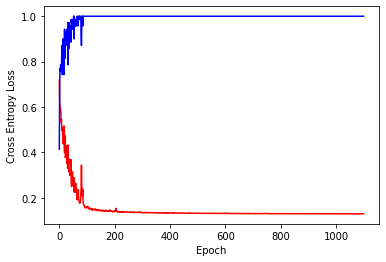

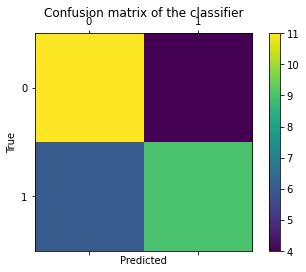

In [111]:
class RegularizedLinear(nn.Linear):
    def __init__(self, *args, ar_weight=1e-3, l1_weight=1e-3, l2_weight=2, **kwargs):
        super(RegularizedLinear, self).__init__(*args, **kwargs)
        #self.ar_weight = ar_weight
        #self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self._losses = {}

    def forward(self, input):
        output = super(RegularizedLinear, self).forward(input)
        #self._losses['activity_regularization'] = (output * output).sum() * self.ar_weight
        #self._losses['l1_weight_regularization'] = torch.abs(self.weight).sum() * self.l1_weight
        self._losses['l2_weight_regularization'] = torch.abs(torch.mul(self.weight,self.weight)).sum() * self.l2_weight
        return output

class FFNNetwork_Regularized(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        #nn.Dropout(0.2),
        RegularizedLinear(54, 250), 
        nn.BatchNorm1d(250),
        #nn.Dropout(0.2),
        Hakuna_Matata(-2,1),
        #nn.Tanh(),
        RegularizedLinear(250,72), 
        nn.BatchNorm1d(72),
        nn.Dropout(0.2),
        Hakuna_Matata(-2,1),
        #nn.Tanh(),
        RegularizedLinear(72, 2), 
        nn.BatchNorm1d(2),
        #nn.Dropout(0.1),
        Hakuna_Matata(-2,1),
        #nn.Tanh(),   
        #RegularizedLinear(n_persons, n_persons), 
        #nn.BatchNorm1d(n_persons),
#        nn.Dropout(0.1),
        #Hakuna_Matata(-1,1),
        #nn.Tanh(),   
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

  def softmax(self,x):
    return torch.exp(x)/torch.sum(torch.exp(x))

  def cross_entropy(self,pred,label):
    yl=torch.mul(pred,label)
    yl=yl[yl!=0]
    yl=-torch.log(yl)
    yl=torch.mean(yl)
    return yl

  def accuracy(self,y_hat, y):
    pred = torch.argmax(y_hat, dim=1)
    return (pred == torch.argmax(y, dim=1)).float().mean()

  def predict(self, X):
    Y_pred = self.forward(x)
    return np.array(Y_pred).squeeze()
  
  def accuracy_n(self,y_hat, y,topk=(1,)):
    maxk = max(topk)
    batch_size = y.size(0)

    _, pred = y_hat.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(torch.argmax(y, dim=1).view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
  
    return res

Y_pred_FFNN, accuracy_FFNN, model = run_FFNN(X_train_scaled,X_val_scaled,Y_OH_train,Y_OH_val,Epochs=1100,save_fig=True)

## Saving Model

In [0]:
torch.save(model.state_dict(),path+"/Outputs/CLASS_FFNNetwork.txt")

1


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss before training 0.6971744589426531
Loss after training 0.1273631098897005
Time for training model: 18.846s
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 75.0


2


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss before training 0.6939426874376133
Loss after training 0.12734952482387873
Time for training model: 18.747s
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 60.0


3


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss before training 0.7111253943783514
Loss after training 0.12735627124692317
Time for training model: 18.656s
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 55.0


4


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss before training 0.6878698316914797
Loss after training 0.12735771755379252
Time for training model: 18.588s
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 70.0


5


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss before training 0.6780350295230593
Loss after training 0.12735544350700176
Time for training model: 19.219s
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 70.0




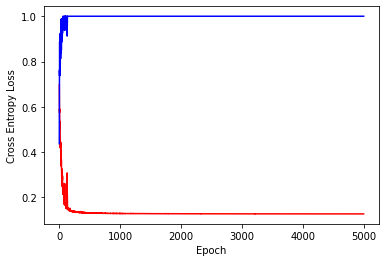

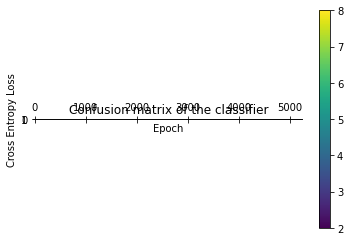

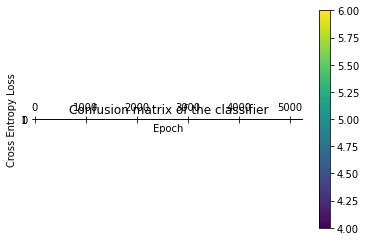

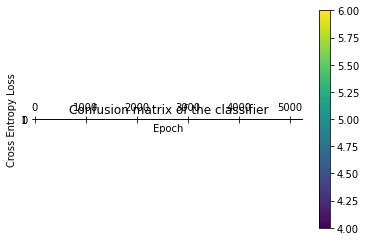

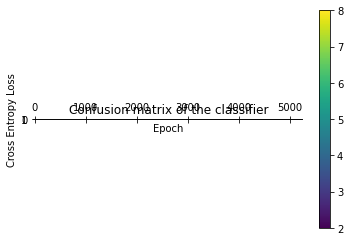

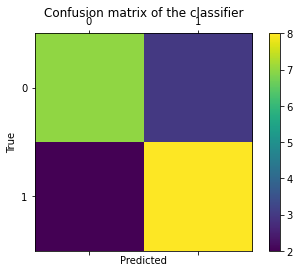

In [0]:
k=5
kf = KFold(n_splits=k)
scaler = StandardScaler()
male_scaled_data = scaler.fit_transform(male_data)
female_scaled_data = scaler.fit_transform(female_data)
ctr = 1
for train_index, test_index in kf.split(male_scaled_data):
  print(ctr)
  male_train, male_test = male_scaled_data[train_index], male_scaled_data[test_index]
  female_train, female_test = female_scaled_data[train_index], female_scaled_data[test_index]

  train_data = np.row_stack((male_train, female_train))
  train_class = np.append(np.zeros(male_train.shape[0]),np.ones(female_train.shape[0]))
  test_data = np.row_stack((male_test, female_test))
  test_class = np.append(np.zeros(male_test.shape[0]),np.ones(female_test.shape[0]))
  
  enc = OneHotEncoder()
  Y_OH_train = enc.fit_transform(np.expand_dims(train_class,1)).toarray()
  Y_OH_val = enc.fit_transform(np.expand_dims(test_class,1)).toarray()

  X_train_scaled, Y_train,Y_OH_train, X_val_scaled, Y_val,Y_OH_val = map(torch.tensor, (train_data, train_class,Y_OH_train, test_data, test_class,Y_OH_val))

  X_train_scaled = X_train_scaled.float()
  Y_train = Y_train.long()

  X_val_scaled = X_val_scaled.float()
  Y_val = Y_val.long()
  Y_pred_FFNN, accuracy_FFNN, model = run_FFNN(X_train_scaled,X_val_scaled,Y_OH_train,Y_OH_val,Epochs=5000,save_fig=True,save_name="{}".format(ctr),save_dir=path+'Outputs/')
  del X_train_scaled, Y_train,Y_OH_train, X_val_scaled, Y_val,Y_OH_val
  torch.cuda.empty_cache()
  torch.save(model.state_dict(),path+"/Outputs/CLASS_FFNNetwork_{}.txt".format(ctr))
  ctr += 1

# Perceptron Model (using sigmoid neuron)

In [0]:
class SigmoidNeuron:
  
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def grad_w(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, save_loss_plot=False, name=None):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if save_loss_plot:
      loss = np.array([])
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        dw += self.grad_w(x, y)
        db += self.grad_b(x, y)       
      self.w -= learning_rate * dw
      self.b -= learning_rate * db
      
      if save_loss_plot:
        Y_pred = self.sigmoid(self.perceptron(X))
        if(loss.size == 0):
          loss = np.array([mean_squared_error(Y_pred, Y)])
        else:
          loss = np.append(loss,mean_squared_error(Y_pred, Y))
    
    if save_loss_plot:
      plt.plot(loss)
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      if(name == None):
        plt.savefig("loss_plot.png")  
        plt.close()
      else:
        plt.savefig("{}.png".format(name))
        plt.close()
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

In [0]:
scaler = StandardScaler()
male_scaled_data = scaler.fit_transform(male_data)
female_scaled_data = scaler.fit_transform(female_data)
male_train, male_test = train_test_split(male_scaled_data, test_size = 0.3)
female_train, female_test = train_test_split(female_scaled_data, test_size = 0.3)
sn = SigmoidNeuron()
train_data = np.row_stack((male_train, female_train))
train_class = np.append(np.zeros(male_train.shape[0]),np.ones(female_train.shape[0]))
sn.fit(train_data, train_class, epochs=2000, learning_rate=0.015, save_loss_plot=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [0]:
test_data = np.row_stack((male_test, female_test))
test_class = np.append(np.zeros(male_test.shape[0]),np.ones(female_test.shape[0]))
Y_pred_train = sn.predict(train_data)
Y_pred_test = sn.predict(test_data)
scaled_threshold = 0.5
Y_pred_binarised_train = (Y_pred_train > scaled_threshold).astype("int").ravel()
Y_pred_binarised_test = (Y_pred_test > scaled_threshold).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, train_class)
accuracy_test  = accuracy_score(Y_pred_binarised_test, test_class)
print("Accuracy on training data = {} %".format(accuracy_train*100))
print("Accuracy on testing data = {} %".format(accuracy_test*100))
#print(accuracy_train*100, accuracy_test)

Accuracy on training data = 81.42857142857143 %
Accuracy on testing data = 53.333333333333336 %


## k-fold cross validation

## Enter k value to be used for k-fold cross validation

In [0]:
k = 10

In [0]:
kf = KFold(n_splits=k)
scaler = StandardScaler()
male_scaled_data = scaler.fit_transform(male_data)
female_scaled_data = scaler.fit_transform(female_data)
ctr = 0
train_accuracy = np.zeros(k)
test_accuracy = np.zeros(k)
for train_index, test_index in kf.split(male_scaled_data):
  male_train, male_test = male_scaled_data[train_index], male_scaled_data[test_index]
  female_train, female_test = female_scaled_data[train_index], female_scaled_data[test_index]
  sn = SigmoidNeuron()
  train_data = np.row_stack((male_train, female_train))
  train_class = np.append(np.zeros(male_train.shape[0]),np.ones(female_train.shape[0]))
  sn.fit(train_data, train_class, epochs=2000, learning_rate=0.015, save_loss_plot=True,name="loss_plot_{}_{}".format(k,ctr))
  test_data = np.row_stack((male_test, female_test))
  test_class = np.append(np.zeros(male_test.shape[0]),np.ones(female_test.shape[0]))
  Y_pred_train = sn.predict(train_data)
  Y_pred_test = sn.predict(test_data)
  scaled_threshold = 0.5
  Y_pred_binarised_train = (Y_pred_train > scaled_threshold).astype("int").ravel()
  Y_pred_binarised_test = (Y_pred_test > scaled_threshold).astype("int").ravel()
  accuracy_train = accuracy_score(Y_pred_binarised_train, train_class)
  accuracy_test  = accuracy_score(Y_pred_binarised_test, test_class)
  print("Accuracy on training data = {} %".format(accuracy_train*100))
  print("Accuracy on testing data = {} %".format(accuracy_test*100))
  print("\n")
  train_accuracy[ctr] = accuracy_train*100
  test_accuracy[ctr] = accuracy_test*100
  ctr += 1
print("Mean Accuracy on training data = {} %".format(np.mean(train_accuracy)))
print("Mean Accuracy on testing data = {} %".format(np.mean(test_accuracy)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy on training data = 80.0 %
Accuracy on testing data = 50.0 %




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy on training data = 82.22222222222221 %
Accuracy on testing data = 60.0 %




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy on training data = 63.33333333333333 %
Accuracy on testing data = 20.0 %




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy on training data = 78.88888888888889 %
Accuracy on testing data = 50.0 %




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy on training data = 75.55555555555556 %
Accuracy on testing data = 50.0 %




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy on training data = 73.33333333333333 %
Accuracy on testing data = 50.0 %




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy on training data = 81.11111111111111 %
Accuracy on testing data = 60.0 %




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy on training data = 74.44444444444444 %
Accuracy on testing data = 40.0 %




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy on training data = 74.44444444444444 %
Accuracy on testing data = 60.0 %




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy on training data = 76.66666666666667 %
Accuracy on testing data = 50.0 %


Mean Accuracy on training data = 76.0 %
Mean Accuracy on testing data = 49.0 %


## **Inferences:**

1. We observe that the average accuracy on training data is best among all the three considered classifiers used, but the average accuracy on testing data is still poor.  

2. We observe that the training accuracy is low only for one of the case during k-fold cross validation process. This one bad value has results in drop in mean accuracy value on both training and testing samples. Else, the mean accuracy to better than all the above considered classifiers (>50% accuracy)
  
3. Here, we have used k-fold cross validation to remove bias due to inital seeding of the training and testing samples. Then, we have computed the mean values of accuracy across the k-fold values.